    # CNC fault detection task
Toy SNN net to test minimum necessary for fault detection.<br /> 
The net is a 12 neurons network with 10 leaky integrate-and-fire and 2 output neurons.<br /> 
The hidden layer has different beta values from 0.4 to 0.8 to act as a bank of low pass filters.<br /> 
This choice allows the network to classify different vibration armonics to detect failures.<br /> 
This repo depends on snntorch and the CNC machining dataset from Bosch:<br /> 
Paper https://doi.org/10.1016/j.procir.2022.04.022<br /> 
Repo for the dataset https://github.com/boschresearch/CNC_Machining<br /> 
Once downloaded, put the dataset folder in the same folder of CNC_toy.<br /> 


### Importing Libraries

In [10]:
import os, torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import snntorch as snn
import snntorch.functional as SF
from snntorch import spikeplot as splt
from CNC_Machining.utils import data_loader_utils
import matplotlib.pyplot as plt
from snntorch import surrogate

dtype = torch.float
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
# device = torch.device("cpu")

## if you're on M1 or M2 GPU:
# device = torch.device("mps")

### Loading CNC dataset

In [11]:
# Defining naming schemes to load dataset files
machines = ["M01", "M02", "M03"]
process_names = [
    "OP00",
    "OP01",
    "OP02",
    "OP03",
    "OP04",
    "OP05",
    "OP06",
    "OP07",
    "OP08",
    "OP09",
    "OP10",
    "OP11",
    "OP12",
    "OP13",
    "OP14",
]
labels = ["good", "bad"]
path_to_dataset = "./CNC_Machining/data/"  # dataset location

Plotting a single file to check if the loader works

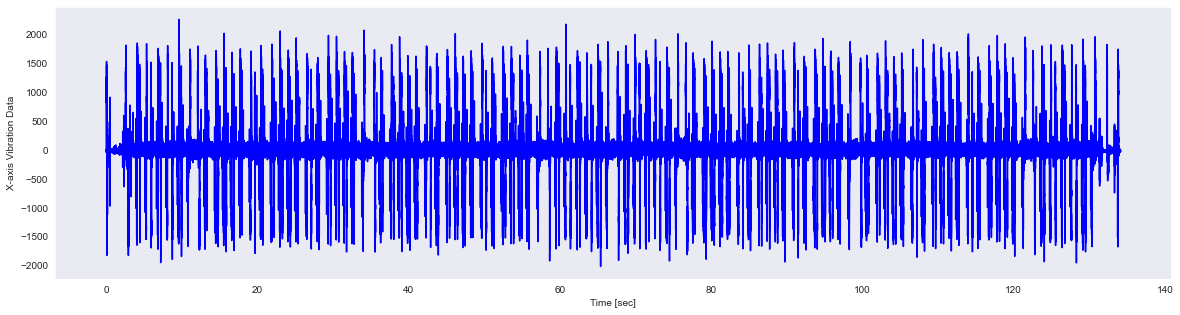

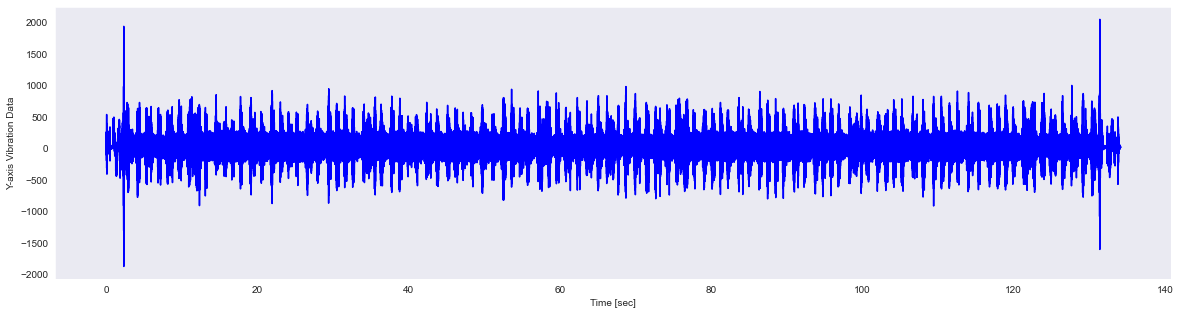

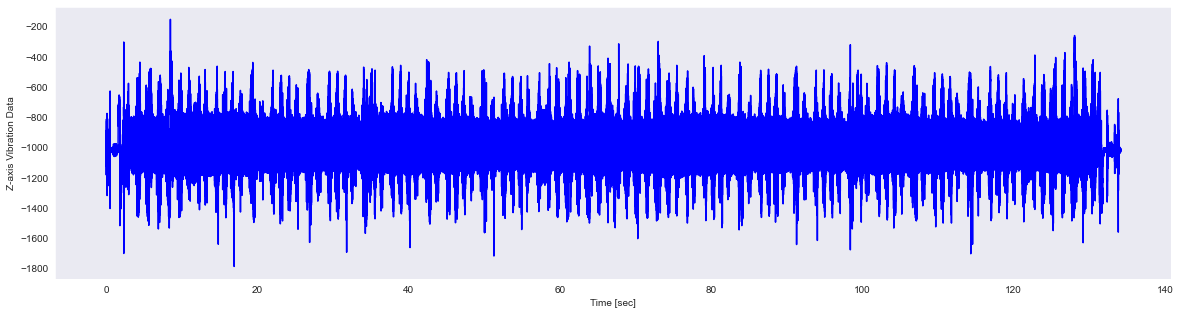

In [12]:
file = path_to_dataset + "M01/OP00/good/M01_Aug_2019_OP00_000.h5"
sample = data_loader_utils.datafile_read(file)

There are a few problems with the data above:<br /> 
X and Y fluctuate a lot under 0 while Z is always negative<br /> 
This might cause first layer neurons to not activate. <br /> 
To solve this problem we need to rectify and normalize the data.<br /> 
This is done in the code below<br /> 

In [13]:
X_data = []
y_data = []
class_count = {}

# To avoid problems with firing rate we can rectify the signal and normalize the max

dataset_max = 0
for process_name in process_names:
    for machine in machines:
        for label in labels:
            data_path = os.path.join(path_to_dataset, machine, process_name, label)
            data_list, data_label = data_loader_utils.load_tool_research_data(
                data_path, label=label
            )

            # Rectify
            for data_i, data in enumerate(data_list):
                data = data - np.mean(data, axis=0)
                data[data < 0] = -data[data < 0]
                data_list[data_i] = data
                if np.max(np.abs(data)) > dataset_max:
                    dataset_max = np.max(np.abs(data))

            # concatenating
            X_data.extend(data_list)
            y_data.extend(data_label)

n_recs = len(y_data)

cnc_data_info_type = [
    ("machine", "U3"),
    ("process", "U4"),
    ("class", "U4"),
    ("rec_date", "U10"),
    ("idx", "U4"),
    ("n_samples", np.int32),
]
cnc_data_info = np.zeros(n_recs, dtype=cnc_data_info_type)

for label_i, label in enumerate(y_data):
    d_machine = label[:3]
    d_process = label[13:17]
    d_class = label[22:]
    d_rec_date = label[4:12]
    d_idx = label[18:21]
    d_n_samples = len(X_data[label_i])
    cnc_data_info[label_i] = np.array(
        [(d_machine, d_process, d_class, d_rec_date, d_idx, d_n_samples)],
        dtype=cnc_data_info_type,
    )

class_count["good"] = sum(cnc_data_info["class"] == "good")
class_count["bad"] = sum(cnc_data_info["class"] == "bad")

# Normalize data
for data_i, data in enumerate(X_data):
    X_data[data_i] = data / dataset_max

laoding files from ./CNC_Machining/data/M01/OP00/good... 
laoding files from ./CNC_Machining/data/M01/OP00/bad... 
laoding files from ./CNC_Machining/data/M02/OP00/good... 
laoding files from ./CNC_Machining/data/M02/OP00/bad... 
laoding files from ./CNC_Machining/data/M03/OP00/good... 
laoding files from ./CNC_Machining/data/M03/OP00/bad... 
laoding files from ./CNC_Machining/data/M01/OP01/good... 
laoding files from ./CNC_Machining/data/M01/OP01/bad... 
laoding files from ./CNC_Machining/data/M02/OP01/good... 
laoding files from ./CNC_Machining/data/M02/OP01/bad... 
laoding files from ./CNC_Machining/data/M03/OP01/good... 
laoding files from ./CNC_Machining/data/M03/OP01/bad... 
laoding files from ./CNC_Machining/data/M01/OP02/good... 
laoding files from ./CNC_Machining/data/M01/OP02/bad... 
laoding files from ./CNC_Machining/data/M02/OP02/good... 
laoding files from ./CNC_Machining/data/M02/OP02/bad... 
laoding files from ./CNC_Machining/data/M03/OP02/good... 
laoding files from ./C

As can be seen from the class_count below, the dataset is highly unbalanced: 

In [14]:
class_count  # the dataset is unbalanced

{'good': 1632, 'bad': 70}

### Extracting a balanced dataset subset

A quick fix to this problem is to reduce the number of good examples,<br /> 
by extracting a subset of our dataset.<br /> 
For every "bad" example, we extract a matching "good" <br /> 
example for the same machine, process and date of recording and index.

In [15]:
bad_subset_idx = cnc_data_info["class"] == "bad"
good_subset_idx = cnc_data_info["class"] == "good"
bad_subset = cnc_data_info[bad_subset_idx]
dataset_idx = []

n_axis = 3  # Choose the number of MEM axis to input to the net

train_batches_number = 2

for bad_rec_i, bad_rec in enumerate(bad_subset):
    good_match_idx = np.ones(n_recs, dtype=np.int32)
    good_match_idx = good_match_idx * (bad_rec["machine"] == cnc_data_info["machine"])
    good_match_idx = good_match_idx * (bad_rec["process"] == cnc_data_info["process"])
    good_match_idx = good_match_idx * (bad_rec["rec_date"] == cnc_data_info["rec_date"])
    good_match_idx = good_match_idx * (bad_rec["idx"] == cnc_data_info["idx"])
    bad_match_idx = good_match_idx * bad_subset_idx
    good_match_idx = good_match_idx * good_subset_idx
    bad_match_idx = np.where(bad_match_idx == 1)[0]
    good_match_idx = np.where(good_match_idx == 1)[0]
    if good_match_idx.size > 0:
        dataset_idx.append(good_match_idx[0])
        dataset_idx.append(bad_match_idx[0])

dataset_idx = np.array(dataset_idx)
print("Total number of matched recordings: " + str(len(dataset_idx)))

Total number of matched recordings: 122


Now we devide this subset in train and test set<br />.
We simply use all the index 000 couples of recording as training <br /> 
and the rest of the indices as testing<br /> 

To limit the complexity of the task we are going to use only <br /> 
machine 01 "M01" recordings <br /> 

In [16]:
dataset_idx_train_good = []
dataset_idx_train_bad = []
dataset_idx_test_good = []
dataset_idx_test_bad = []

for idx in dataset_idx:
    info = cnc_data_info[idx]

    if info["machine"] == "M01":
        # Split the training set and the test set along idx
        if info["idx"] == "000":
            if info["class"] == "good":
                dataset_idx_train_good.append(idx)
            else:
                dataset_idx_train_bad.append(idx)
        else:
            if info["class"] == "good":
                dataset_idx_test_good.append(idx)
            else:
                dataset_idx_test_bad.append(idx)

train_idx = dataset_idx_train_good + dataset_idx_train_bad
test_idx = dataset_idx_test_good + dataset_idx_test_bad

train_batch_size = len(train_idx)
test_batch_size = len(test_idx)
print("Train single batch size: " + str(train_batch_size))
print("Test single batch size: " + str(test_batch_size))
# min_train_samples = min(cnc_data_info[train_idx]["n_samples"])
# min_test_samples = min(cnc_data_info[test_idx]["n_samples"])
min_train_samples = 1000
min_test_samples = 1000

# Create the actual train and test set by batching batch_i*n_samples*batch_size*3(IMUdim)
# train_data = np.zeros([train_batch_size, min_train_samples,1,n_axis])
# test_data = np.zeros([test_batch_size, min_test_samples,1,n_axis])
train_data = np.zeros([min_train_samples, train_batch_size, n_axis])
test_data = np.zeros([min_test_samples, test_batch_size, n_axis])

train_labels = 1 * (cnc_data_info[train_idx]["class"] == "bad")
test_labels = 1 * (cnc_data_info[test_idx]["class"] == "bad")

for j, train_i in enumerate(train_idx):
    # train_data[j,:,0] = X_data[train_i][:min_train_samples,:n_axis]
    train_data[:, j] = X_data[train_i][:min_train_samples, :n_axis]

for j, test_i in enumerate(test_idx):
    # test_data[j,:,0] = X_data[test_i][:min_test_samples,:n_axis]
    test_data[:, j] = X_data[test_i][:min_test_samples, :n_axis]

train_data = torch.tensor(train_data, dtype=dtype)
train_labels = F.one_hot(torch.tensor(train_labels)).float()
test_data = torch.tensor(test_data, dtype=dtype)
test_labels = F.one_hot(torch.tensor(test_labels)).float()

Train single batch size: 42
Test single batch size: 20


ValueError: could not broadcast input array from shape (38983,3) into shape (40000,3)

### Single Neuron Sim
Little digression on a single neuron simulation to test the decay parameters on the dataset.
I need to move it to neuron_sym.ipynb to unclutter

In [9]:
# @title Plotting Settings
def plot_cur_mem_spk(
    cur,
    mem,
    spk,
    thr_line=False,
    vline=False,
    title=False,
    ylim_max1=1.25,
    ylim_max2=1.25,
):
    # Generate Plots
    fig, ax = plt.subplots(
        3, figsize=(8, 6), sharex=True, gridspec_kw={"height_ratios": [1, 1, 0.4]}
    )

    # Plot input current
    ax[0].plot(cur, c="tab:orange")
    ax[0].set_ylim([0, ylim_max1])
    ax[0].set_xlim([0, 200])
    ax[0].set_ylabel("Input Current ()")
    if title:
        ax[0].set_title(title)

    # Plot membrane potential
    ax[1].plot(mem)
    ax[1].set_ylim([0, ylim_max2])
    ax[1].set_ylabel("Membrane Potential ()")
    if thr_line:
        ax[1].axhline(
            y=thr_line, alpha=0.25, linestyle="dashed", c="black", linewidth=2
        )
    plt.xlabel("Time step")

    # Plot output spike using spikeplot
    splt.raster(spk, ax[2], s=400, c="black", marker="|")
    if vline:
        ax[2].axvline(
            x=vline,
            ymin=0,
            ymax=6.75,
            alpha=0.15,
            linestyle="dashed",
            c="black",
            linewidth=2,
            zorder=0,
            clip_on=False,
        )
    plt.ylabel("Output spikes")
    plt.yticks([])

    plt.show()


def plot_snn_spikes(spk_in, spk1_rec, spk2_rec, title):
    # Generate Plots
    fig, ax = plt.subplots(
        3, figsize=(8, 7), sharex=True, gridspec_kw={"height_ratios": [1, 1, 0.4]}
    )

    # Plot input spikes
    splt.raster(spk_in[:, 0], ax[0], s=0.03, c="black")
    ax[0].set_ylabel("Input Spikes")
    ax[0].set_title(title)

    # Plot hidden layer spikes
    splt.raster(spk1_rec.reshape(num_steps, -1), ax[1], s=0.05, c="black")
    ax[1].set_ylabel("Hidden Layer")

    # Plot output spikes
    splt.raster(spk2_rec.reshape(num_steps, -1), ax[2], c="black", marker="|")
    ax[2].set_ylabel("Output Spikes")
    ax[2].set_ylim([0, 10])

    plt.show()


def dvs_animator(spike_data):
    fig, ax = plt.subplots()
    anim = splt.animator((spike_data[:, 0] + spike_data[:, 1]), fig, ax)
    return anim

In [10]:
beta_test = 0.8
threshold_test = 0.1
lif = snn.Leaky(beta=beta_test, threshold=threshold_test)  # LIF neuron

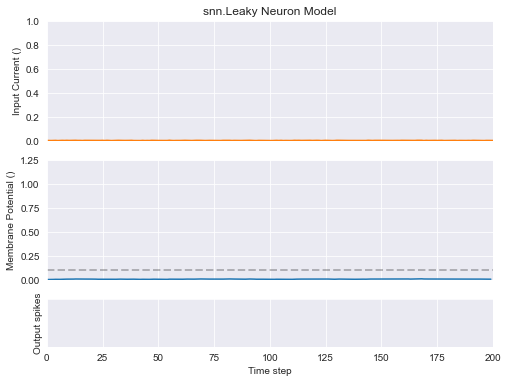

In [11]:
# setup inputs
num_steps = 200  # number of time-steps to simulate

x = train_data[:, 0, :1].sum(1)

# Small step current input
# w = 0.15, # then run 0.20, 0.21
# x = torch.cat((torch.zeros(10), torch.ones(190)*w), 0)
mem = torch.zeros(1)
spk = torch.zeros(1)

mem_rec = []
spk_rec = []

# neuron simulation
for step in range(num_steps):
    spk, mem = lif(x[step], mem)
    mem_rec.append(mem)
    spk_rec.append(spk)

# convert lists to tensors
mem_rec = torch.stack(mem_rec)
spk_rec = torch.stack(spk_rec)

plot_cur_mem_spk(
    x,
    mem_rec,
    spk_rec,
    thr_line=threshold_test,
    ylim_max1=1.0,
    title="snn.Leaky Neuron Model",
)

# Training a simple SNN

Finally we train our SNN <br /> 
We limit the network to two layers and 10 hidden neurons <br /> 
We also limit beta for the hidden neuron (hid_beta) to values between 0.4 and 0.8 <br /> 
I made tau_calculator.py I need to comment, to find the beta values <br /> 

In [12]:
training = False

In [13]:
# Network Architecture
num_inputs = n_axis
num_hidden = 10
num_outputs = 2

# Temporal Dynamics
num_steps = min_train_samples
hid_beta = np.linspace(0.4, 0.8, num_hidden)
hid_beta = torch.tensor(hid_beta, dtype=dtype)
out_beta = 0.95
hid_thresh = 0.1
thresh = 0.9

Building the network with pytoch.<br /> 
Important: <br /> 

        1) The network does not work if we set a bias in the linear layer,
           this would cause the neurons to increase a constant making no sense.
           
        2) The starting weights for layer 1 are set to 1,
           this allows to avoid neurons not firing at the begginning.

        3) I set spike grad to a smooth and particularly slow gaussian,
           otherwise the network fails to converge or simply takes too much time.

           

In [14]:
# Function to measure accuracy
def measure_accuracy(spk_rec, targets):
    with torch.no_grad():
        running_length = 0
        running_accuracy = 0

        spike_count = spk_rec.sum(0)
        _, max_spike = spike_count.max(1)

        # correct classes for one batch
        num_correct = (max_spike == torch.argmax(targets, dim=1)).sum()

        # total accuracy
        running_length += len(targets)
        running_accuracy += num_correct

        accuracy = running_accuracy / running_length

        return accuracy.item()


# La sigmoide piú smooth aiuta a ridurre la loss sin da subito,
# Adam risolve il problema di instabilitá dato dal raggiungimento del minimo della rete.
spike_grad = surrogate.fast_sigmoid(slope=0.05)


# Define Network
class Net(nn.Module):
    def __init__(self):
        super().__init__()

        # Initialize layers
        self.fc1 = nn.Linear(num_inputs, num_hidden, bias=False)
        # self.fc1 = nn.Linear(num_inputs, num_hidden)
        # self.fc1.bias.data = torch.tensor(0.01)
        self.fc1.weight.data = torch.ones(self.fc1.weight.size())
        self.lif1 = snn.Leaky(
            beta=hid_beta, threshold=hid_thresh, spike_grad=spike_grad
        )
        # self.fc2 = nn.Linear(num_hidden, num_outputs)
        # self.fc2.bias.data = torch.tensor(0.01)
        self.fc2 = nn.Linear(num_hidden, num_outputs, bias=False)
        self.fc2.weight.data = torch.abs(self.fc2.weight.data)
        self.lif2 = snn.Leaky(beta=out_beta, threshold=thresh, spike_grad=spike_grad)

    def forward(self, x):
        # Initialize hidden states at t=0
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()

        # Record the final layer
        spk2_rec = []
        mem2_rec = []

        # Also part of the first for debug
        spk1_rec = []

        num_steps = len(x)

        for step in range(num_steps):
            cur1 = self.fc1(x[step])
            spk1, mem1 = self.lif1(cur1, mem1)
            cur2 = self.fc2(spk1)
            spk2, mem2 = self.lif2(cur2, mem2)
            spk2_rec.append(spk2)
            mem2_rec.append(mem2)
            spk1_rec.append(spk1)

        return (
            torch.stack(spk2_rec, dim=0),
            torch.stack(mem2_rec, dim=0),
            torch.stack(spk1_rec, dim=0),
        )


# Load the network onto CUDA if available
net = Net().to(device)

Let's train!

In [15]:
if training == True:
    loss = SF.ce_count_loss()
    optimizer = torch.optim.Adam(net.parameters(), lr=2e-3)
    
    num_epochs = 450
    loss_story = []
    accuracy_story = []
    
    data = train_data.to(device)
    targets = train_labels.to(device)
    
    # Outer training loop
    for epoch in range(num_epochs):
        # forward pass
        net.train()
        spk_rec, mem_rec, spk_rec_hid = net(data)
    
        # initialize the loss & sum over time
        loss_val = loss(spk_rec, torch.argmax(targets, axis=1))
        acc = measure_accuracy(spk_rec, targets)
    
        # Gradient calculation + weight update
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()
    
        # Store loss history for future plotting
        loss_story.append(loss_val.item())
        accuracy_story.append(acc)
    
        # Print train/test loss/accuracy
        print(f"Iteration: {epoch} \t Train Loss: {loss_val.item()}")
        print(f"Train set accuracy: {acc}")

In [16]:
if training == True:
    save_f = "Save/"
    
    plt.figure()
    plt.plot(loss_story)
    plt.title("Network Loss")
    plt.xlabel("Epoch")
    plt.savefig(save_f + "net1_train_loss.svg")
    
    plt.figure()
    plt.plot(accuracy_story)
    plt.title("Network Accuracy")
    plt.xlabel("Epoch")
    plt.savefig(save_f + "net1_train_accuracy.svg")

Run test!

In [17]:
def measure_test_accuracy(model, test_data, test_targets):
    with torch.no_grad():
        model.eval()
        running_length = 0
        running_accuracy = 0

        data = test_data.to(device)
        targets = test_targets.to(device)

        # forward-pass
        spk_rec, _, spk_rec_hid = model(data)
        spike_count = spk_rec.sum(0)
        _, max_spike = spike_count.max(1)

        # correct classes for one batch
        num_correct = (max_spike == torch.argmax(targets, axis=1)).sum()

        # total accuracy
        running_length += len(targets)
        running_accuracy += num_correct

        accuracy = running_accuracy / running_length

        return accuracy.item()


print(f"Test Accuracy: {measure_test_accuracy(net, test_data, test_labels)}")

Test Accuracy: 0.5


### Save network and results

In [18]:
if training == True:
    save_f = "Save/"
    torch.save(net.state_dict(), save_f + "net1.pth")
    np.save(save_f + "net1_train_loss.npy", loss_story)
    np.save(save_f + "net1_train_accuracy.npy", accuracy_story)

### Load network and results

In [19]:
save_f = "Save/"
# Remember to generate the network before loading the parameters
net.load_state_dict(torch.load(save_f + "net1.pth"))
loss_story = np.load(save_f + "net1_train_loss.npy")
accuracy_story = np.load(save_f + "net1_train_accuracy.npy")

## Activity Plots (Michele)
Before Plotting we need to get the net response to a file 

In [20]:
# Run the test set
net.eval()

data = test_data.to(device)
targets = test_labels.to(device)

# forward-pass
spk_rec, mem_rec, spk_rec_hid = net(data)
## spk_rec is time x batch x neuron

spike_count = spk_rec.sum(0)
_, max_spike = spike_count.max(1)

# correct classes for one batch
num_correct = (max_spike == torch.argmax(targets, axis=1)).sum()

In [28]:
num_correct

tensor(20, device='cuda:0')

In [21]:
spk_rec.cpu().detach().numpy()  # Output spikes
targets.cpu().detach().numpy()  # Hidden layer spikes
spk_rec_hid.cpu().detach().numpy()  # Recording label

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 1., 1., 1.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [1., 1., 1., ..., 1., 1., 1.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1.

In [22]:
spk_rec_idx = torch.where(spk_rec == 1)
print(spk_rec_idx)

(tensor([  3,   4,   5,  ..., 999, 999, 999], device='cuda:0'), tensor([16, 18, 14,  ..., 18, 19, 19], device='cuda:0'), tensor([1, 1, 0,  ..., 1, 0, 1], device='cuda:0'))


In [23]:
spk_rec_hid_idx = torch.where(spk_rec_hid == 1)
print(spk_rec_hid_idx)
print(spk_rec_hid.shape)

(tensor([  2,   2,   2,  ..., 999, 999, 999], device='cuda:0'), tensor([18, 18, 18,  ..., 19, 19, 19], device='cuda:0'), tensor([7, 8, 9,  ..., 7, 8, 9], device='cuda:0'))
torch.Size([1000, 20, 10])


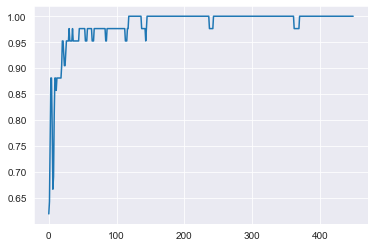

In [24]:
import matplotlib.pyplot as plt

plt.plot(accuracy_story)

In [25]:
(int(spk_rec_hid[0,0,0].detach().cpu().numpy().item()) == 1)

False

SAVE THE NECESSARY FILES FOR PLOTTING

In [26]:
save_f = "Save/"
freq = 2000
# data = data.cpu().detach().numpy()
samples_s = len(data[:, 0,0]) / freq
samples = np.linspace(0, samples_s, len(data[:, 0,0]))
np.save(save_f + "vibr_time.npy",samples)
np.save(save_f + "vibr.npy",data.cpu().detach().numpy())
np.save(save_f + "spk_rec_hid.npy",spk_rec_hid.cpu().detach().numpy())
np.save(save_f + "spk_rec.npy",spk_rec.cpu().detach().numpy())
np.save(save_f + "max_spikes.npy",max_spike.cpu().detach().numpy())
np.save( save_f + "targets.npy",targets.cpu().detach().numpy())